In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from tslearn.metrics import cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.metrics.pairwise import cosine_distances
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [48]:
df = pd.read_csv("covid_19_data.csv")
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [49]:
df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])

daily_country = df.groupby(["Country/Region", "ObservationDate"]).agg({
    "Confirmed": "sum",
    "Deaths": "sum",
    "Recovered": "sum"
}).reset_index()

print(f"Daily country data shape: {daily_country.shape}")
print(f"Date range: {daily_country['ObservationDate'].min()} to {daily_country['ObservationDate'].max()}")
print(f"Unique countries: {daily_country['Country/Region'].nunique()}")

Daily country data shape: (87281, 5)
Date range: 2020-01-22 00:00:00 to 2021-05-29 00:00:00
Unique countries: 229


In [33]:
daily_country = daily_country.sort_values(["Country/Region", "ObservationDate"])

daily_country["new_cases"] = daily_country.groupby("Country/Region")["Confirmed"].diff().fillna(0)
daily_country["new_deaths"] = daily_country.groupby("Country/Region")["Deaths"].diff().fillna(0)

daily_country.loc[daily_country["new_cases"] < 0, "new_cases"] = 0
daily_country.loc[daily_country["new_deaths"] < 0, "new_deaths"] = 0

print("New cases computed:")
print(daily_country[daily_country["Country/Region"] == "US"].head(10))

New cases computed:
      Country/Region ObservationDate  Confirmed  Deaths  Recovered  new_cases  \
81663             US      2020-01-22        1.0     0.0        0.0        0.0   
81664             US      2020-01-23        1.0     0.0        0.0        0.0   
81665             US      2020-01-24        2.0     0.0        0.0        1.0   
81666             US      2020-01-25        2.0     0.0        0.0        0.0   
81667             US      2020-01-26        5.0     0.0        0.0        3.0   
81668             US      2020-01-27        5.0     0.0        0.0        0.0   
81669             US      2020-01-28        5.0     0.0        0.0        0.0   
81670             US      2020-01-29        5.0     0.0        0.0        0.0   
81671             US      2020-01-30        5.0     0.0        0.0        0.0   
81672             US      2020-01-31        6.0     0.0        0.0        1.0   

       new_deaths  
81663         0.0  
81664         0.0  
81665         0.0  
81666   

In [34]:
daily_country["year"] = daily_country["ObservationDate"].dt.isocalendar().year
daily_country["week"] = daily_country["ObservationDate"].dt.isocalendar().week

weekly_data = daily_country.groupby(["Country/Region", "year", "week"]).agg({
    "new_cases": "sum",
    "new_deaths": "sum",
    "Confirmed": "max",
    "Deaths": "max",
    "Recovered": "max"
}).reset_index()

print(f"Weekly aggregated data shape: {weekly_data.shape}")
weekly_data.head()

Weekly aggregated data shape: (12612, 8)


,Country/Region,year,week,new_cases,new_deaths,Confirmed,Deaths,Recovered
0,Azerbaijan,2020,9,0.0,0.0,1.0,0.0,0.0
1,"('St. Martin',)",2020,11,0.0,0.0,2.0,0.0,0.0
2,Afghanistan,2020,9,0.0,0.0,1.0,0.0,0.0
3,Afghanistan,2020,10,4.0,0.0,5.0,0.0,0.0
4,Afghanistan,2020,11,11.0,0.0,16.0,0.0,0.0


In [35]:
country_summary = weekly_data.groupby("Country/Region").agg({
    "new_cases": ["sum", "count", "max"],
    "week": "count"
}).reset_index()

country_summary.columns = ["Country/Region", "total_new_cases", "week_count", "max_weekly_cases", "total_weeks"]
country_summary = country_summary.sort_values("total_new_cases", ascending=False)

print("Top 20 countries by total new cases:")
print(country_summary.head(20))

Top 20 countries by total new cases:
     Country/Region  total_new_cases  week_count  max_weekly_cases  \
214              US       33251938.0          71         1722285.0   
96            India       27894799.0          70         2737058.0   
27           Brazil       16471600.0          67          536455.0   
71           France        6072474.0          71          376591.0   
212          Turkey        5235977.0          64         1008433.0   
172          Russia        4995618.0          70          198847.0   
213              UK        4534213.0          70          418669.0   
102           Italy        4213201.0          70          243425.0   
194           Spain        3766840.0          70          247396.0   
8         Argentina        3732262.0          65          232199.0   
77          Germany        3684668.0          70          164152.0   
44         Colombia        3363061.0          66          130605.0   
98             Iran        2893216.0          67     

In [36]:
min_weeks = 20
min_total_cases = 1000

eligible = country_summary[
    (country_summary["week_count"] >= min_weeks) & 
    (country_summary["total_new_cases"] >= min_total_cases)
]

print(f"\nCountries with >= {min_weeks} weeks and >= {min_total_cases} total cases: {len(eligible)}")
print(f"Eligible countries: {eligible['Country/Region'].tolist()}")


Countries with >= 20 weeks and >= 1000 total cases: 179
Eligible countries: ['US', 'India', 'Brazil', 'France', 'Turkey', 'Russia', 'UK', 'Italy', 'Spain', 'Argentina', 'Germany', 'Colombia', 'Iran', 'Poland', 'Mexico', 'Ukraine', 'Peru', 'Indonesia', 'Netherlands', 'Czech Republic', 'South Africa', 'Canada', 'Chile', 'Philippines', 'Iraq', 'Romania', 'Sweden', 'Belgium', 'Pakistan', 'Portugal', 'Israel', 'Hungary', 'Bangladesh', 'Japan', 'Jordan', 'Serbia', 'Switzerland', 'Austria', 'United Arab Emirates', 'Malaysia', 'Nepal', 'Lebanon', 'Morocco', 'Saudi Arabia', 'Kazakhstan', 'Ecuador', 'Bulgaria', 'Greece', 'Belarus', 'Slovakia', 'Panama', 'Bolivia', 'Croatia', 'Paraguay', 'Tunisia', 'Georgia', 'Azerbaijan', 'Costa Rica', 'West Bank and Gaza', 'Kuwait', 'Dominican Republic', 'Uruguay', 'Denmark', 'Lithuania', 'Ethiopia', 'Egypt', 'Moldova', 'Ireland', 'Guatemala', 'Slovenia', 'Honduras', 'Bahrain', 'Venezuela', 'Armenia', 'Qatar', 'Oman', 'Bosnia and Herzegovina', 'Libya', 'Sri La

In [37]:
priority_countries = ["US", "Brazil", "Denmark", "Italy", "Germany", "Japan", "France", "Spain", "United Kingdom"]

china_variants = ["China", "Mainland China", "Macau", "Hong Kong"]
for variant in china_variants:
    if variant in eligible["Country/Region"].values:
        priority_countries.insert(0, variant)
        print(f"Found China variant: {variant}")
        break

selected_countries = [c for c in priority_countries if c in eligible["Country/Region"].values]

if len(selected_countries) < 10:
    additional = [c for c in eligible["Country/Region"].tolist() if c not in selected_countries]
    selected_countries.extend(additional[:10 - len(selected_countries)])

print(f"\nSelected {len(selected_countries)} countries:")
print(selected_countries)

Found China variant: Mainland China

Selected 10 countries:
['Mainland China', 'US', 'Brazil', 'Denmark', 'Italy', 'Germany', 'Japan', 'France', 'Spain', 'India']


In [39]:
print("\n1. Analyzing each country's data range in weekly_data:")
print(f"{'Country':<20s} {'First Week':<15s} {'Last Week':<15s} {'Total Weeks':<12s}")
print("-"*70)

last_valid_weeks = {}

for country in selected_countries:
    country_data = weekly_data[weekly_data["Country/Region"] == country].copy()
    
    if len(country_data) > 0:
        country_data = country_data.sort_values(["year", "week"])
        
        first_row = country_data.iloc[0]
        last_row = country_data.iloc[-1]
        
        first_week = (first_row["year"], first_row["week"])
        last_week = (last_row["year"], last_row["week"])
        
        last_valid_weeks[country] = last_week
        
        print(f"{country:<20s} {first_week[0]}-W{first_week[1]:02d}      {last_week[0]}-W{last_week[1]:02d}      {len(country_data):<12d}")
    else:
        print(f"{country:<20s} NO DATA")

if last_valid_weeks:
    min_last_week = min(last_valid_weeks.values())
    country_with_min = [k for k, v in last_valid_weeks.items() if v == min_last_week][0]
    
    print(f"\n2. Earliest ending week across all countries:")
    print(f"   Week: {min_last_week[0]}-W{min_last_week[1]:02d}")
    print(f"   Country: {country_with_min}")
    print(f"   Decision: Truncate all countries to this week")
    
    print(f"\n3. Filtering weekly_data to remove weeks after {min_last_week[0]}-W{min_last_week[1]:02d}...")
    
    original_len = len(weekly_data)
    
    weekly_data_filtered = weekly_data[
        (weekly_data["year"] < min_last_week[0]) | 
        ((weekly_data["year"] == min_last_week[0]) & (weekly_data["week"] <= min_last_week[1]))
    ].copy()
    
    filtered_len = len(weekly_data_filtered)
    
    print(f"   Original weekly_data: {original_len} rows")
    print(f"   Filtered weekly_data: {filtered_len} rows")
    print(f"   Removed: {original_len - filtered_len} rows")


1. Analyzing each country's data range in weekly_data:
Country              First Week      Last Week       Total Weeks 
----------------------------------------------------------------------
Mainland China       2020-W04      2021-W21      71          
US                   2020-W04      2021-W21      71          
Brazil               2020-W04      2021-W21      67          
Denmark              2020-W09      2021-W21      66          
Italy                2020-W05      2021-W21      70          
Germany              2020-W05      2021-W21      70          
Japan                2020-W04      2021-W21      71          
France               2020-W04      2021-W21      71          
Spain                2020-W05      2021-W21      70          
India                2020-W05      2021-W21      70          

2. Earliest ending week across all countries:
   Week: 2021-W21
   Country: Mainland China
   Decision: Truncate all countries to this week

3. Filtering weekly_data to remove weeks afte

In [40]:
ts_data = weekly_data_filtered[weekly_data_filtered["Country/Region"].isin(selected_countries)].copy()

pivot_new_cases = ts_data.pivot_table(
    index="Country/Region",
    columns=["year", "week"],
    values="new_cases",
    fill_value=0
)

actual_data_mask = weekly_data.pivot_table(
    index="Country/Region",
    columns=["year", "week"],
    values="new_cases",
    aggfunc=lambda x: 1, 
    fill_value=0  
)

print("Data quality analysis:")
for country in pivot_new_cases.index:
    mask = actual_data_mask.loc[country]
    data_weeks_idx = np.where(mask == 1)[0]
    
    if len(data_weeks_idx) > 0:
        first_data = data_weeks_idx[0]
        last_data = data_weeks_idx[-1]
        leading_zeros = first_data
        trailing_zeros = len(mask) - last_data - 1
        
        print(f"\n{country}:")
        print(f"  First data at week {first_data}, last at week {last_data}")
        print(f"  Leading zeros: {leading_zeros} weeks")
        print(f"  Trailing zeros: {trailing_zeros} weeks")
        
        if leading_zeros > 10:
            print(f"Note: Late start (Week {first_data}) - may indicate late pandemic arrival")
        
        if trailing_zeros > 5:
            print(f"Warning: {trailing_zeros} weeks without data at end - trajectory may be truncated")

print(f"\nTime series matrix shape: {pivot_new_cases.shape}")
print(f"Countries: {list(pivot_new_cases.index)}")
print(f"Weeks: {pivot_new_cases.shape[1]}")

for country in pivot_new_cases.index:
    total = pivot_new_cases.loc[country].sum()
    nonzero = (pivot_new_cases.loc[country] > 0).sum()
    print(f"  {country:25s}: total={total:>10.0f}, nonzero_weeks={nonzero:>3}/{pivot_new_cases.shape[1]}")

Data quality analysis:

Brazil:
  First data at week 0, last at week 70
  Leading zeros: 0 weeks
  Trailing zeros: 0 weeks

Denmark:
  First data at week 5, last at week 70
  Leading zeros: 5 weeks
  Trailing zeros: 0 weeks

France:
  First data at week 0, last at week 70
  Leading zeros: 0 weeks
  Trailing zeros: 0 weeks

Germany:
  First data at week 1, last at week 70
  Leading zeros: 1 weeks
  Trailing zeros: 0 weeks

India:
  First data at week 1, last at week 70
  Leading zeros: 1 weeks
  Trailing zeros: 0 weeks

Italy:
  First data at week 1, last at week 70
  Leading zeros: 1 weeks
  Trailing zeros: 0 weeks

Japan:
  First data at week 0, last at week 70
  Leading zeros: 0 weeks
  Trailing zeros: 0 weeks

Mainland China:
  First data at week 0, last at week 70
  Leading zeros: 0 weeks
  Trailing zeros: 0 weeks

Spain:
  First data at week 1, last at week 70
  Leading zeros: 1 weeks
  Trailing zeros: 0 weeks

US:
  First data at week 0, last at week 70
  Leading zeros: 0 weeks
 

In [41]:
min_nonzero_weeks = 10

valid_countries = []
for country in pivot_new_cases.index:
    nonzero_count = (pivot_new_cases.loc[country] > 0).sum()
    if nonzero_count >= min_nonzero_weeks:
        valid_countries.append(country)

pivot_new_cases = pivot_new_cases.loc[valid_countries]

print(f"\nAfter filtering: {len(valid_countries)} countries remain")
print(f"Final matrix shape: {pivot_new_cases.shape}")


After filtering: 10 countries remain
Final matrix shape: (10, 71)


In [42]:
scaler = MinMaxScaler()
timeseries_normalized = scaler.fit_transform(pivot_new_cases.T).T

timeseries_array = timeseries_normalized
country_names = pivot_new_cases.index.tolist()

print(f"\nNormalized time series shape: {timeseries_array.shape}")
print(f"Countries: {country_names}")

for idx, country in enumerate(country_names):
    print(f"  {country:25s}: min={timeseries_array[idx].min():.4f}, max={timeseries_array[idx].max():.4f}, mean={timeseries_array[idx].mean():.4f}")


Normalized time series shape: (10, 71)
Countries: ['Brazil', 'Denmark', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Mainland China', 'Spain', 'US']
  Brazil                   : min=0.0000, max=1.0000, mean=0.4325
  Denmark                  : min=0.0000, max=1.0000, mean=0.1609
  France                   : min=0.0000, max=1.0000, mean=0.2271
  Germany                  : min=0.0000, max=1.0000, mean=0.3162
  India                    : min=0.0000, max=1.0000, mean=0.1435
  Italy                    : min=0.0000, max=1.0000, mean=0.2438
  Japan                    : min=0.0000, max=1.0000, mean=0.2404
  Mainland China           : min=0.0000, max=1.0000, mean=0.0413
  Spain                    : min=0.0000, max=1.0000, mean=0.2145
  US                       : min=0.0000, max=1.0000, mean=0.2719


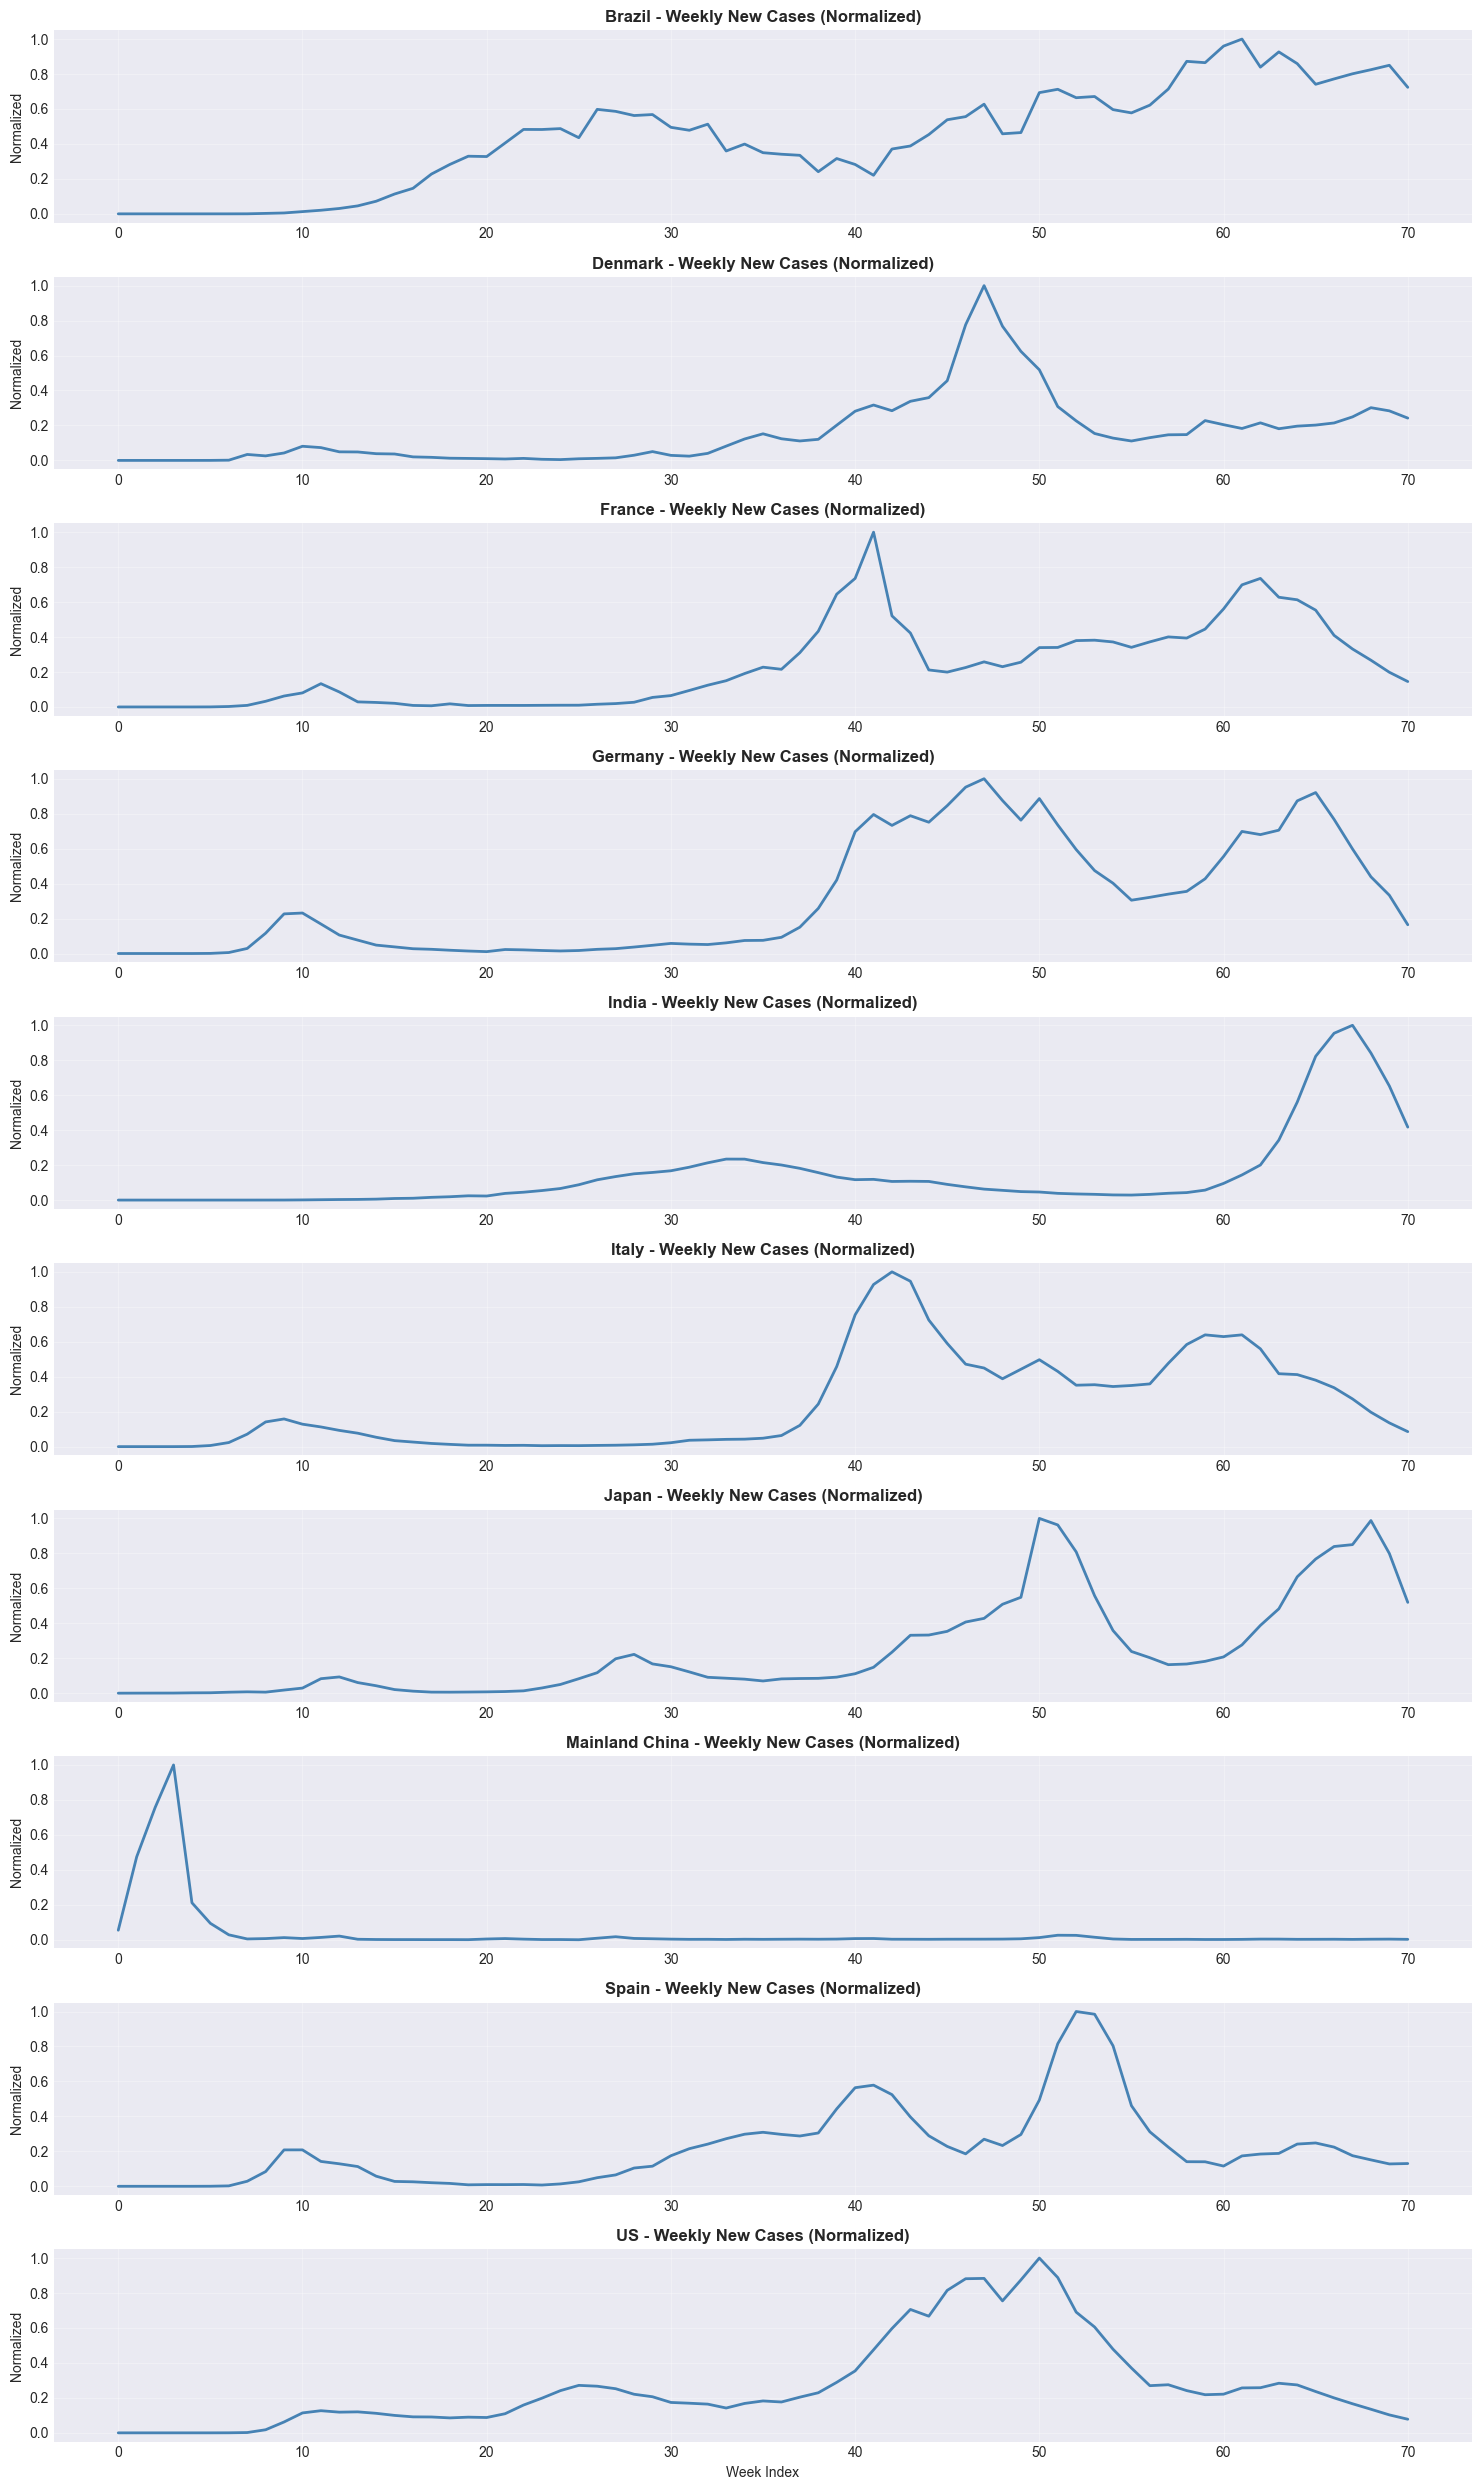


Data preparation complete!


In [43]:
fig, axes = plt.subplots(len(country_names), 1, figsize=(15, 2.5 * len(country_names)))

if len(country_names) == 1:
    axes = [axes]

for idx, country in enumerate(country_names):
    axes[idx].plot(timeseries_array[idx], linewidth=2, color='steelblue')
    axes[idx].set_title(f'{country} - Weekly New Cases (Normalized)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Normalized')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-0.05, 1.05)

axes[-1].set_xlabel('Week Index')
plt.tight_layout()
plt.savefig('01_timeseries_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nData preparation complete!")

In [57]:
print("Computing DTW distance matrix...")
dtw_distance_matrix = cdist_dtw(timeseries_array,n_jobs=-1)
print(f"DTW distance matrix shape: {dtw_distance_matrix.shape}")

print("Computing Cosine distance matrix...")
cosine_distance_matrix = cosine_distances(timeseries_array)
print(f"Cosine distance matrix shape: {cosine_distance_matrix.shape}")

print("\nDistance matrix statistics:")
print(f"DTW:")
print(f"  Min: {dtw_distance_matrix.min():.6f}")
print(f"  Max: {dtw_distance_matrix.max():.6f}")
print(f"  Mean: {dtw_distance_matrix.mean():.6f}")

print(f"\nCosine:")
print(f"  Min: {cosine_distance_matrix.min():.6f}")
print(f"  Max: {cosine_distance_matrix.max():.6f}")
print(f"  Mean: {cosine_distance_matrix.mean():.6f}")

Computing DTW distance matrix...
DTW distance matrix shape: (10, 10)
Computing Cosine distance matrix...
Cosine distance matrix shape: (10, 10)

Distance matrix statistics:
DTW:
  Min: 0.000000
  Max: 4.115950
  Mean: 1.097810

Cosine:
  Min: 0.000000
  Max: 0.988596
  Mean: 0.374525


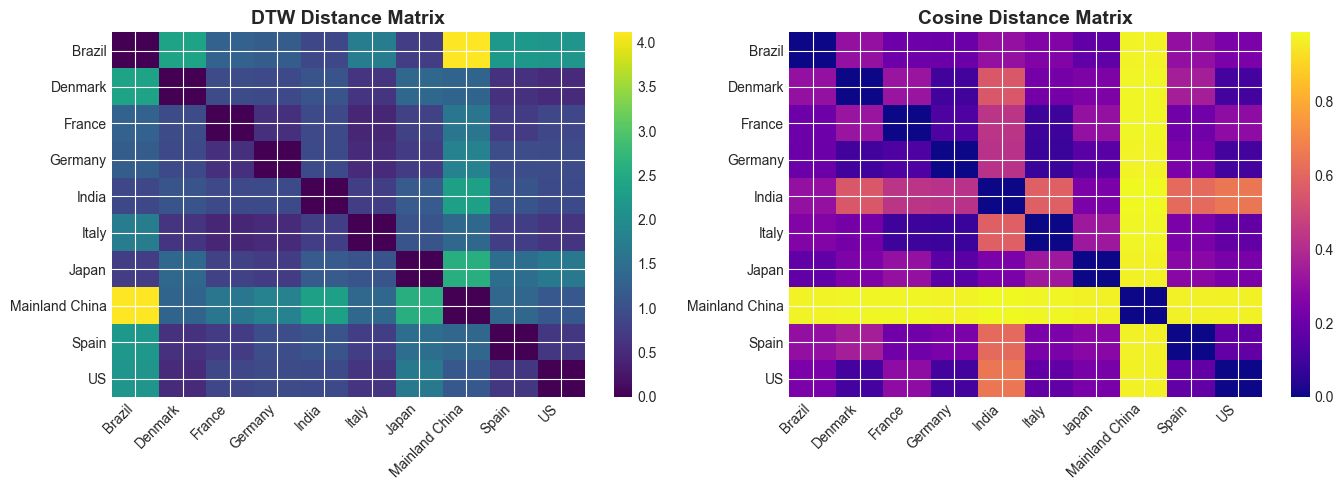

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(dtw_distance_matrix, cmap='viridis', aspect='auto', vmin=0)
axes[0].set_title('DTW Distance Matrix', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(country_names)))
axes[0].set_yticks(range(len(country_names)))
axes[0].set_xticklabels(country_names, rotation=45, ha='right')
axes[0].set_yticklabels(country_names)
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(cosine_distance_matrix, cmap='plasma', aspect='auto', vmin=0)
axes[1].set_title('Cosine Distance Matrix', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(country_names)))
axes[1].set_yticks(range(len(country_names)))
axes[1].set_xticklabels(country_names, rotation=45, ha='right')
axes[1].set_yticklabels(country_names)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('02_distance_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

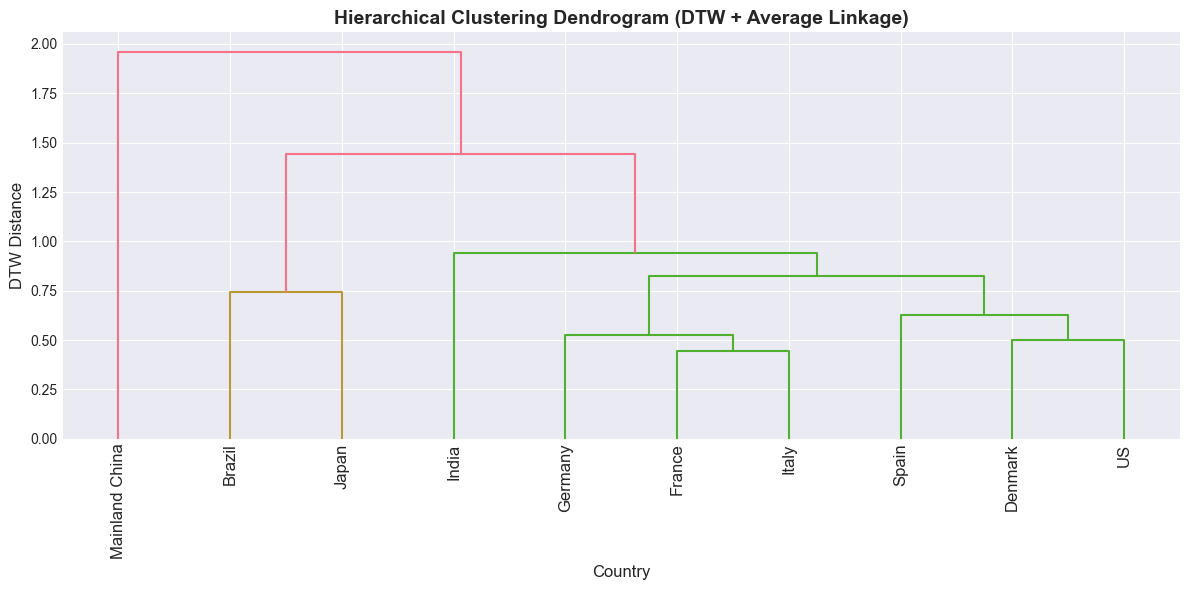

In [55]:
linkage_dtw_avg = linkage(squareform(dtw_distance_matrix), method='average')

plt.figure(figsize=(12, 6))
dendrogram(linkage_dtw_avg, labels=country_names, leaf_rotation=90, leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram (DTW + Average Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('DTW Distance', fontsize=12)
plt.tight_layout()
plt.savefig('03_dendrogram_dtw_avg.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
max_k = min(8, len(country_names) - 1)
k_range = range(2, max_k + 1)

silhouette_scores_dtw = []
db_scores_dtw = []

for k in k_range:
    labels = fcluster(linkage_dtw_avg, k, criterion='maxclust')
    
    sil_score = silhouette_score(dtw_distance_matrix, labels, metric='precomputed')
    silhouette_scores_dtw.append(sil_score)
    
    db_score = davies_bouldin_score(timeseries_array, labels)
    db_scores_dtw.append(db_score)

print("DTW Distance - Evaluation Metrics:")
for k, sil, db in zip(k_range, silhouette_scores_dtw, db_scores_dtw):
    print(f"  k={k}: Silhouette={sil:.3f}, DB Index={db:.3f}")

DTW Distance - Evaluation Metrics:
  k=2: Silhouette=0.370, DB Index=0.526
  k=3: Silhouette=0.319, DB Index=1.153
  k=4: Silhouette=0.197, DB Index=0.882
  k=5: Silhouette=0.233, DB Index=0.935
  k=6: Silhouette=0.182, DB Index=0.731
  k=7: Silhouette=0.122, DB Index=0.582
  k=8: Silhouette=0.069, DB Index=0.464


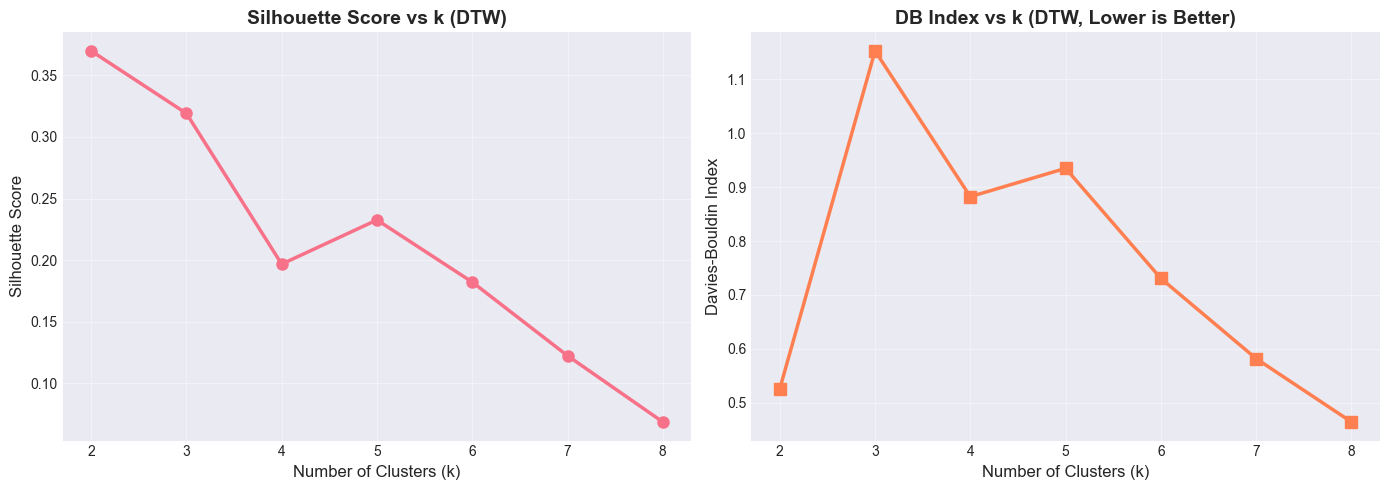

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, silhouette_scores_dtw, marker='o', linewidth=2.5, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score vs k (DTW)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.4)
axes[0].set_xticks(k_range)

axes[1].plot(k_range, db_scores_dtw, marker='s', linewidth=2.5, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('DB Index vs k (DTW, Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.4)
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.savefig('04_metrics_dtw.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
best_k_dtw = k_range[np.argmax(silhouette_scores_dtw)]
best_labels_dtw = fcluster(linkage_dtw_avg, best_k_dtw, criterion='maxclust')

print(f"\nOptimal k (DTW, by Silhouette): {best_k_dtw}")
print(f"Silhouette Score: {max(silhouette_scores_dtw):.3f}")
print(f"DB Index: {db_scores_dtw[best_k_dtw - 2]:.3f}")

print("\nCluster Assignments (DTW):")
for country, label in zip(country_names, best_labels_dtw):
    print(f"  {country}: Cluster {label}")


Optimal k (DTW, by Silhouette): 2
Silhouette Score: 0.370
DB Index: 0.526

Cluster Assignments (DTW):
  Brazil: Cluster 1
  Denmark: Cluster 1
  France: Cluster 1
  Germany: Cluster 1
  India: Cluster 1
  Italy: Cluster 1
  Japan: Cluster 1
  Mainland China: Cluster 2
  Spain: Cluster 1
  US: Cluster 1


In [59]:
unique_labels_dtw = np.unique(best_labels_dtw)
centroids_dtw = {}
cluster_members_dtw = {}

for cluster_id in unique_labels_dtw:
    cluster_mask = (best_labels_dtw == cluster_id)
    cluster_ts = timeseries_array[cluster_mask]
    cluster_members_dtw[cluster_id] = np.where(cluster_mask)[0]
    
    centroid = dtw_barycenter_averaging(cluster_ts, max_iter=50, tol=1e-5)
    centroids_dtw[cluster_id] = centroid
    
    member_countries = [country_names[i] for i in cluster_members_dtw[cluster_id]]
    print(f"Cluster {cluster_id}: {', '.join(member_countries)}")

Cluster 1: Brazil, Denmark, France, Germany, India, Italy, Japan, Spain, US
Cluster 2: Mainland China


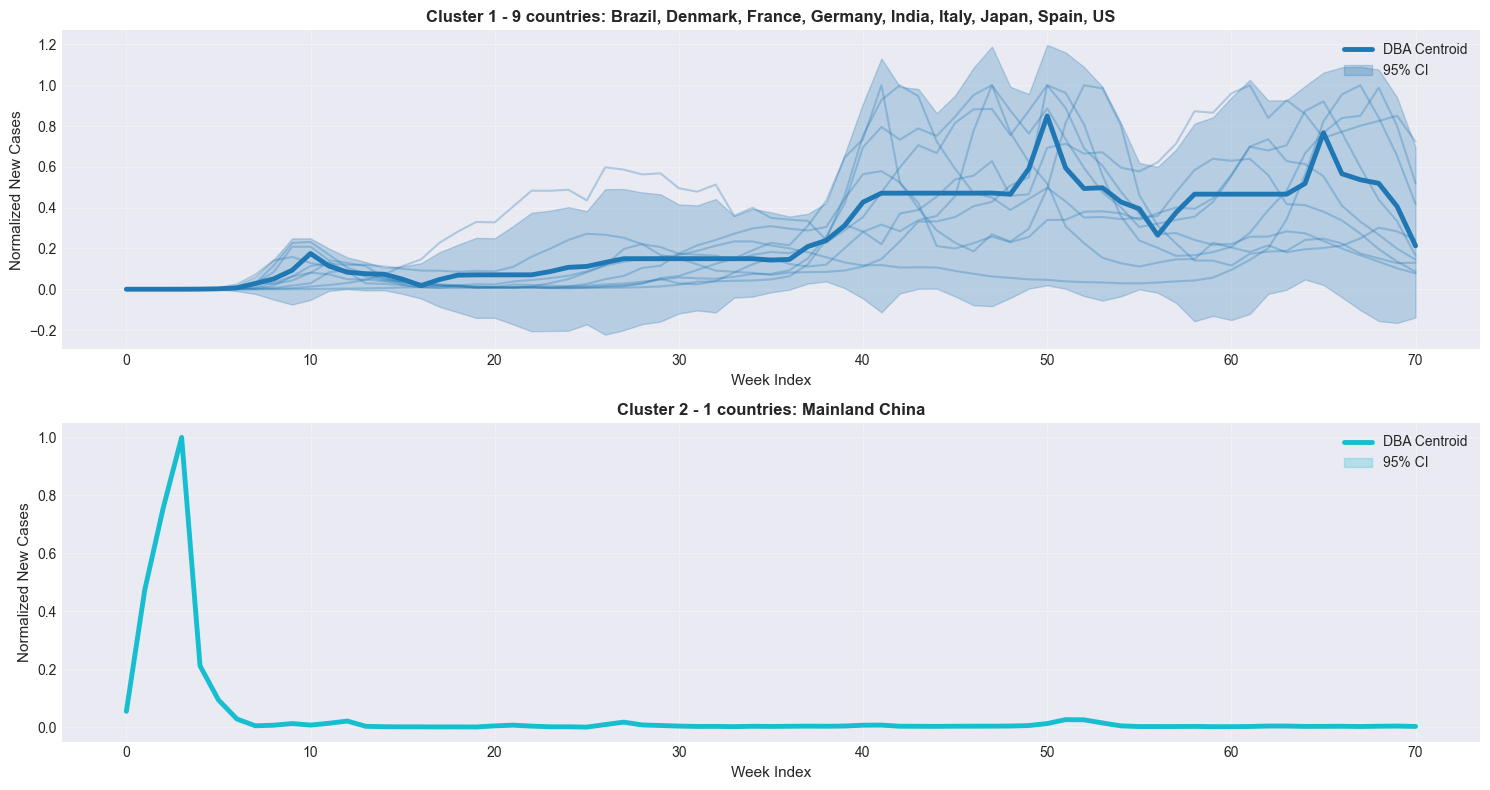

In [60]:
n_clusters_dtw = len(unique_labels_dtw)
fig, axes = plt.subplots(n_clusters_dtw, 1, figsize=(15, 4 * n_clusters_dtw))

if n_clusters_dtw == 1:
    axes = [axes]

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters_dtw))

for idx, cluster_id in enumerate(unique_labels_dtw):
    ax = axes[idx]
    cluster_mask = (best_labels_dtw == cluster_id)
    cluster_ts = timeseries_array[cluster_mask]
    cluster_countries = [country_names[i] for i in np.where(cluster_mask)[0]]
    
    for ts in cluster_ts:
        ax.plot(ts, color=colors[idx], alpha=0.3, linewidth=1.5)
    
    centroid = centroids_dtw[cluster_id]
    ax.plot(centroid, color=colors[idx], linewidth=3.5, label='DBA Centroid', zorder=10)
    
    std_band = np.std(cluster_ts, axis=0)
    mean_curve = np.mean(cluster_ts, axis=0)
    ax.fill_between(
        range(len(mean_curve)),
        mean_curve - 1.96 * std_band,
        mean_curve + 1.96 * std_band,
        color=colors[idx],
        alpha=0.25,
        label='95% CI'
    )
    
    ax.set_title(f'Cluster {cluster_id} - {len(cluster_countries)} countries: {", ".join(cluster_countries)}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Week Index', fontsize=11)
    ax.set_ylabel('Normalized New Cases', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_cluster_trajectories_dtw.png', dpi=300, bbox_inches='tight')
plt.show()

Cosine distances - NaN count: 0
Cosine distances - Inf count: 0
Cosine distances - Min: 0.0827, Max: 0.9886


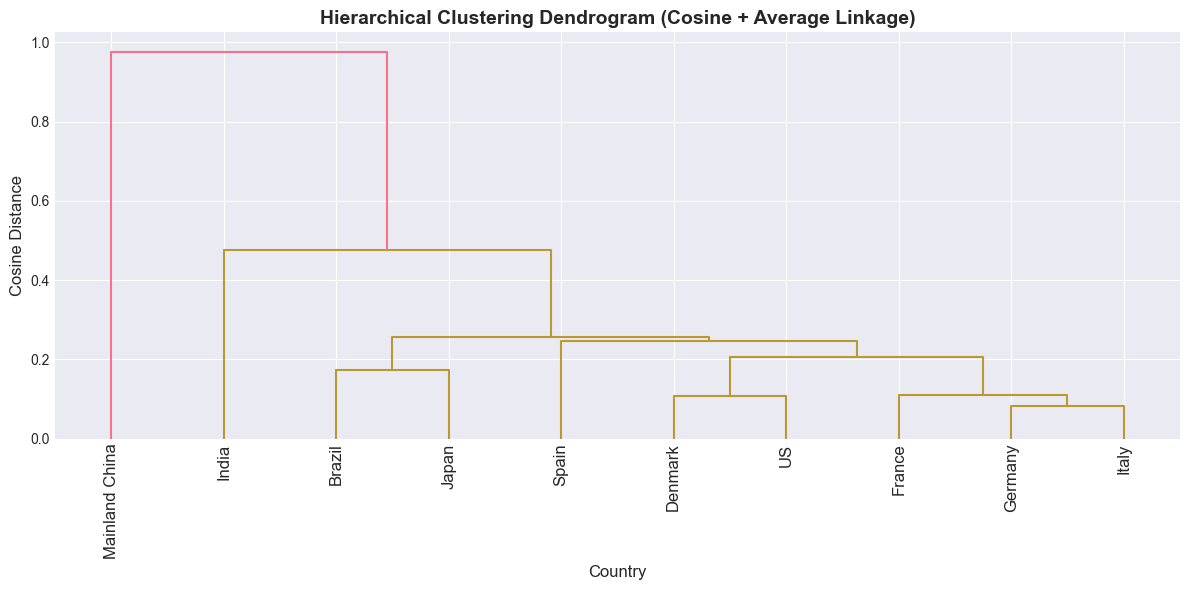

In [69]:
from scipy.spatial.distance import pdist

def compute_cosine_distance_stable(X):
    """Compute cosine distance with numerical stability"""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms < 1e-10, 1.0, norms)
    X_normalized = X / norms
    similarity_matrix = np.dot(X_normalized, X_normalized.T)
    similarity_matrix = np.clip(similarity_matrix, -1.0, 1.0)
    distance_matrix = 1 - similarity_matrix
    np.fill_diagonal(distance_matrix, 0.0)
    condensed = squareform(distance_matrix)
    return condensed

cosine_distances_condensed = compute_cosine_distance_stable(timeseries_array)

print(f"Cosine distances - NaN count: {np.sum(np.isnan(cosine_distances_condensed))}")
print(f"Cosine distances - Inf count: {np.sum(np.isinf(cosine_distances_condensed))}")
print(f"Cosine distances - Min: {np.min(cosine_distances_condensed):.4f}, Max: {np.max(cosine_distances_condensed):.4f}")

linkage_cos_avg = linkage(cosine_distances_condensed, method='average')

plt.figure(figsize=(12, 6))
dendrogram(linkage_cos_avg, labels=country_names, leaf_rotation=90, leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram (Cosine + Average Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Cosine Distance', fontsize=12)
plt.tight_layout()
plt.savefig('06_dendrogram_cosine_avg.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
cosine_distance_matrix_symmetric = squareform(cosine_distances_condensed)

silhouette_scores_cos = []
db_scores_cos = []

for k in k_range:
    labels = fcluster(linkage_cos_avg, k, criterion='maxclust')
    
    sil_score = silhouette_score(cosine_distance_matrix_symmetric, labels, metric='precomputed')
    silhouette_scores_cos.append(sil_score)
    
    db_score = davies_bouldin_score(timeseries_array, labels)
    db_scores_cos.append(db_score)

print("Cosine Distance - Evaluation Metrics:")
for k, sil, db in zip(k_range, silhouette_scores_cos, db_scores_cos):
    print(f"  k={k}: Silhouette={sil:.3f}, DB Index={db:.3f}")

Cosine Distance - Evaluation Metrics:
  k=2: Silhouette=0.646, DB Index=0.526
  k=3: Silhouette=0.382, DB Index=0.579
  k=4: Silhouette=0.210, DB Index=0.882
  k=5: Silhouette=0.177, DB Index=0.824
  k=6: Silhouette=0.246, DB Index=0.772
  k=7: Silhouette=0.194, DB Index=0.582
  k=8: Silhouette=0.092, DB Index=0.533


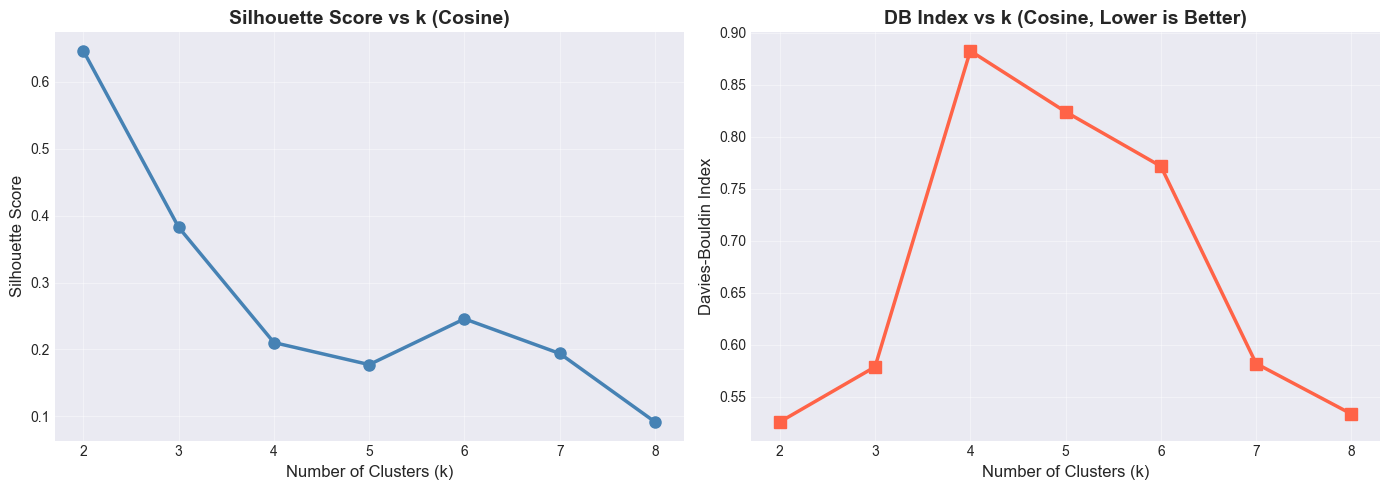

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, silhouette_scores_cos, marker='o', linewidth=2.5, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score vs k (Cosine)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.4)
axes[0].set_xticks(k_range)

axes[1].plot(k_range, db_scores_cos, marker='s', linewidth=2.5, markersize=8, color='tomato')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('DB Index vs k (Cosine, Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.4)
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.savefig('07_metrics_cosine.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
best_k_cos = k_range[np.argmax(silhouette_scores_cos)]
best_labels_cos = fcluster(linkage_cos_avg, best_k_cos, criterion='maxclust')

print(f"\nOptimal k (Cosine, by Silhouette): {best_k_cos}")
print(f"Silhouette Score: {max(silhouette_scores_cos):.3f}")
print(f"DB Index: {db_scores_cos[best_k_cos - 2]:.3f}")

print("\nCluster Assignments (Cosine):")
for country, label in zip(country_names, best_labels_cos):
    print(f"  {country}: Cluster {label}")


Optimal k (Cosine, by Silhouette): 2
Silhouette Score: 0.646
DB Index: 0.526

Cluster Assignments (Cosine):
  Brazil: Cluster 1
  Denmark: Cluster 1
  France: Cluster 1
  Germany: Cluster 1
  India: Cluster 1
  Italy: Cluster 1
  Japan: Cluster 1
  Mainland China: Cluster 2
  Spain: Cluster 1
  US: Cluster 1


In [73]:
unique_labels_cos = np.unique(best_labels_cos)
centroids_cos = {}

for cluster_id in unique_labels_cos:
    cluster_mask = (best_labels_cos == cluster_id)
    cluster_ts = timeseries_array[cluster_mask]
    
    centroid = dtw_barycenter_averaging(cluster_ts, max_iter=50, tol=1e-5)
    centroids_cos[cluster_id] = centroid
    
    member_countries = [country_names[i] for i in np.where(cluster_mask)[0]]
    print(f"Cluster {cluster_id}: {', '.join(member_countries)}")

Cluster 1: Brazil, Denmark, France, Germany, India, Italy, Japan, Spain, US
Cluster 2: Mainland China


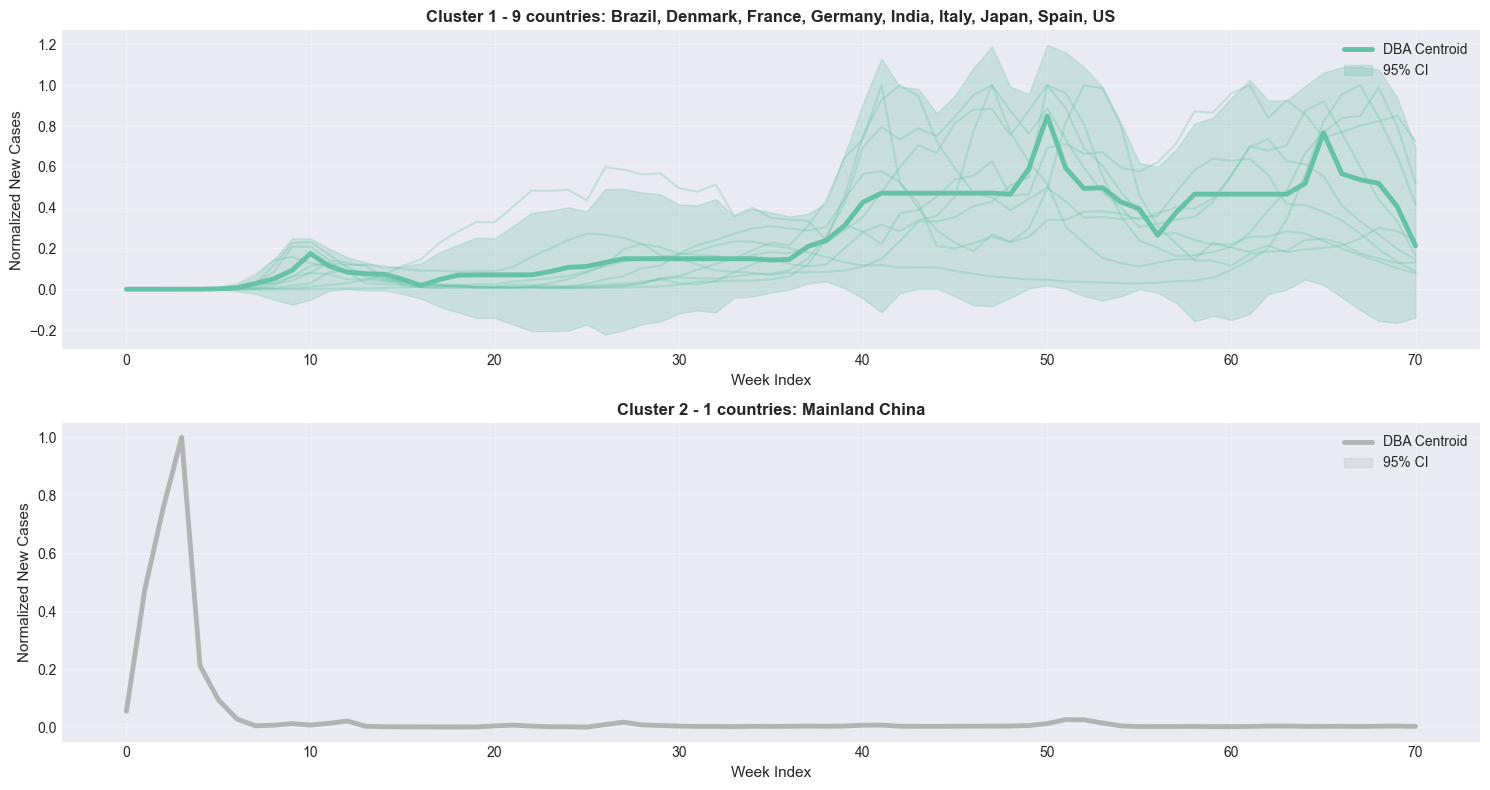

In [74]:
n_clusters_cos = len(unique_labels_cos)
fig, axes = plt.subplots(n_clusters_cos, 1, figsize=(15, 4 * n_clusters_cos))

if n_clusters_cos == 1:
    axes = [axes]

colors = plt.cm.Set2(np.linspace(0, 1, n_clusters_cos))

for idx, cluster_id in enumerate(unique_labels_cos):
    ax = axes[idx]
    cluster_mask = (best_labels_cos == cluster_id)
    cluster_ts = timeseries_array[cluster_mask]
    cluster_countries = [country_names[i] for i in np.where(cluster_mask)[0]]
    
    for ts in cluster_ts:
        ax.plot(ts, color=colors[idx], alpha=0.3, linewidth=1.5)
    
    centroid = centroids_cos[cluster_id]
    ax.plot(centroid, color=colors[idx], linewidth=3.5, label='DBA Centroid', zorder=10)
    
    std_band = np.std(cluster_ts, axis=0)
    mean_curve = np.mean(cluster_ts, axis=0)
    ax.fill_between(
        range(len(mean_curve)),
        mean_curve - 1.96 * std_band,
        mean_curve + 1.96 * std_band,
        color=colors[idx],
        alpha=0.25,
        label='95% CI'
    )
    
    ax.set_title(f'Cluster {cluster_id} - {len(cluster_countries)} countries: {", ".join(cluster_countries)}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Week Index', fontsize=11)
    ax.set_ylabel('Normalized New Cases', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('08_cluster_trajectories_cosine.png', dpi=300, bbox_inches='tight')
plt.show()

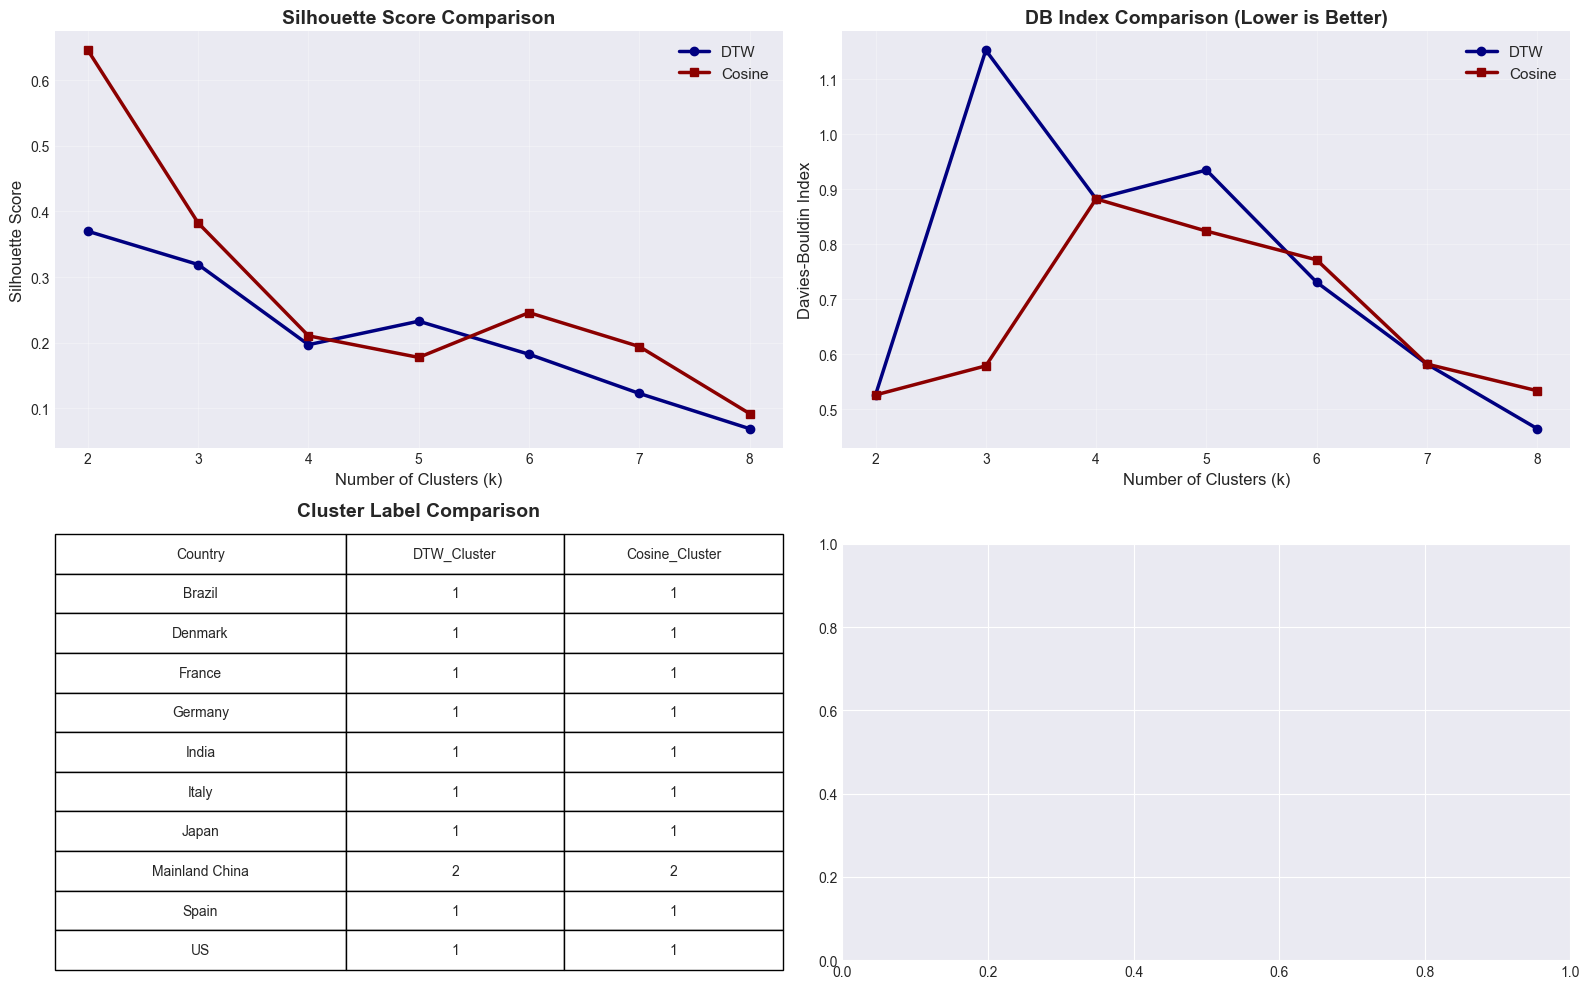


FINAL COMPARISON SUMMARY

DTW Distance:
  Optimal k: 2
  Best Silhouette: 0.370
  Best DB Index: 0.526

Cosine Distance:
  Optimal k: 2
  Best Silhouette: 0.646
  Best DB Index: 0.526

Label Agreement Rate: 100.00%


In [77]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(k_range, silhouette_scores_dtw, marker='o', linewidth=2.5, label='DTW', color='navy')
axes[0, 0].plot(k_range, silhouette_scores_cos, marker='s', linewidth=2.5, label='Cosine', color='darkred')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

axes[0, 1].plot(k_range, db_scores_dtw, marker='o', linewidth=2.5, label='DTW', color='navy')
axes[0, 1].plot(k_range, db_scores_cos, marker='s', linewidth=2.5, label='Cosine', color='darkred')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[0, 1].set_title('DB Index Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)

comparison_df = pd.DataFrame({
    'Country': country_names,
    'DTW_Cluster': best_labels_dtw,
    'Cosine_Cluster': best_labels_cos
})

axes[1, 0].axis('tight')
axes[1, 0].axis('off')
table = axes[1, 0].table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                         cellLoc='center', loc='center', colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1, 0].set_title('Cluster Label Comparison', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('09_comparison_dtw_vs_cosine.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("FINAL COMPARISON SUMMARY")
print("="*60)
print(f"\nDTW Distance:")
print(f"  Optimal k: {best_k_dtw}")
print(f"  Best Silhouette: {max(silhouette_scores_dtw):.3f}")
print(f"  Best DB Index: {db_scores_dtw[best_k_dtw - 2]:.3f}")

print(f"\nCosine Distance:")
print(f"  Optimal k: {best_k_cos}")
print(f"  Best Silhouette: {max(silhouette_scores_cos):.3f}")
print(f"  Best DB Index: {db_scores_cos[best_k_cos - 2]:.3f}")

print(f"\nLabel Agreement Rate: {agreement_rate:.2%}")

In [76]:
summary_data = []
for metric_name, best_k, best_labels, sil_scores, db_scores in [
    ('DTW', best_k_dtw, best_labels_dtw, silhouette_scores_dtw, db_scores_dtw),
    ('Cosine', best_k_cos, best_labels_cos, silhouette_scores_cos, db_scores_cos)
]:
    summary_data.append({
        'Distance Metric': metric_name,
        'Optimal k': best_k,
        'Max Silhouette': max(sil_scores),
        'Min DB Index': min(db_scores),
        'N Clusters': len(np.unique(best_labels))
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("CLUSTERING SUMMARY TABLE")
print("="*60)
print(summary_df.to_string(index=False))


CLUSTERING SUMMARY TABLE
Distance Metric  Optimal k  Max Silhouette  Min DB Index  N Clusters
            DTW          2        0.369809      0.464349           2
         Cosine          2        0.645908      0.525736           2
